# Some concepts around normal D, Hessians etc.

Basically, as per the book, the log of normal D gives a parabola whose differentiation ==0 lies at the *mean* of the curve and whose double differentiation is a constant with the value SD

In [3]:
import tensorflow_probability as tfp
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
normal_D = tfp.distributions.Normal(0.5, 0.08)

In [24]:
normalD_sample = normal_D.sample(1000)

<AxesSubplot:ylabel='Count'>

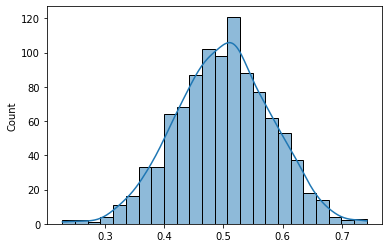

In [25]:
sns.histplot(normalD_sample, kde='dist')

# PLot of log of normal_D

In [26]:
logNormalD_sample = tf.math.log(normalD_sample)

<AxesSubplot:ylabel='Count'>

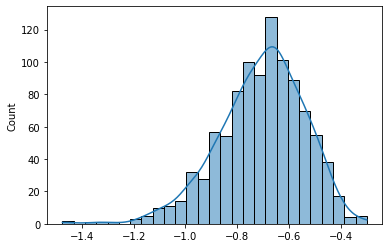

In [46]:
sns.histplot(logNormalD_sample, kde='dist')

In [31]:
tf.reduce_min(normalD_sample), tf.reduce_max(normalD_sample)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.2286115>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.74165547>)

In [30]:
tf.reduce_min(logNormalD_sample), tf.reduce_max(logNormalD_sample)

(<tf.Tensor: shape=(), dtype=float32, numpy=-1.4757313>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.29887047>)

# differentiating w.r.t x

In [66]:
x = tf.linspace(0., 1., 1000)

<AxesSubplot:>

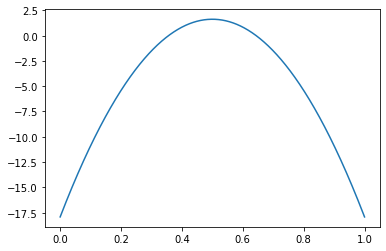

In [69]:
sns.lineplot(x=x, y=tf.math.log(normal_D.prob(x)))

In [73]:
with tf.GradientTape() as tape:
    tape.watch(x)
    y=tf.math.log(normal_D.prob(x))

first_gradient = tape.gradient(y, x)

<AxesSubplot:>

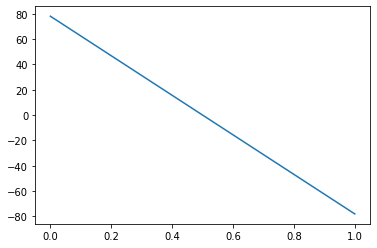

In [75]:
sns.lineplot(x=x, y=first_gradient)

# Thus the mean would be the value of X for which y is 0

In [115]:
first_gradient_1 = first_gradient[first_gradient<0.1]
first_gradient_2 = first_gradient_1[first_gradient_1>-0.1]

In [116]:
first_gradient_2

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.07820129, -0.07820725], dtype=float32)>

In [117]:
tf.where(first_gradient==0.07820129)

<tf.Tensor: shape=(0, 1), dtype=int64, numpy=array([], shape=(0, 1), dtype=int64)>

# Double differential of the function should give the SD

In [123]:
x[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.005005  , 0.00600601, 0.00700701, 0.00800801, 0.00900901],
      dtype=float32)>

In [124]:
first_gradient[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([78.125   , 77.96859 , 77.81219 , 77.655785, 77.499374, 77.34297 ,
       77.18656 , 77.03016 , 76.87375 , 76.71735 ], dtype=float32)>

In [128]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    with tf.GradientTape() as tape2:
        tape2.watch(x)
        y2 = tf.math.log(normal_D.prob(x))
    df1 = tape2.gradient(y2, x)
sec_grad = tape.gradient(df1, x)


In [132]:
tf.sqrt(-tf.reduce_mean(sec_grad))

<tf.Tensor: shape=(), dtype=float32, numpy=12.5>

# Since we cannot find the exact minimum using tf.GradientTape(), we can look into other optimization algos

In [153]:
x = tf.constant(2.)
tfp.math.value_and_gradient(lambda: tf.math.log(x), x)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.6931472>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5>)

In [137]:
def compute_gradient(x):

    with tf.GradientTape() as tape:
        tape.watch(x)
        y = -tf.math.log(normal_D.prob(x))
    grad = tape.gradient(y, x)

    return y, grad

In [165]:
import numpy as np

In [189]:
x = tf.cast(tf.linspace(0, 1, 1000), dtype=tf.float32)


In [187]:
x.shape

TensorShape([1000])

In [176]:
_1, _2 = compute_gradient(x)

In [178]:
tf.shape(_2)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1000,    1])>

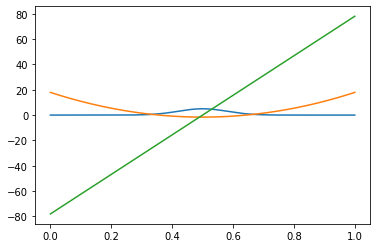

In [191]:
plt.plot(x, normal_D.prob(x))
plt.plot(x, compute_gradient(x)[0])
plt.plot(x, compute_gradient(x)[1])

In [213]:
y, grad = tfp.math.value_and_gradient(lambda x: -tf.math.log(normal_D.prob(x)), x)

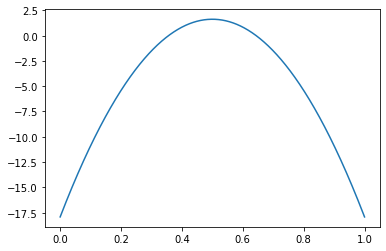

In [200]:
plt.plot(x, tf.math.log(normal_D.prob(x)))

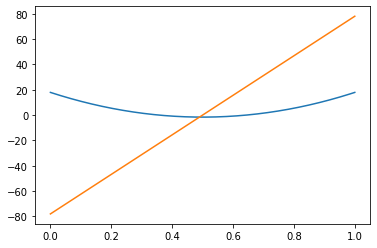

In [215]:
plt.plot(x, y)
plt.plot(x, grad)

In [299]:
def func_to_min(x):
    return tfp.math.value_and_gradient(lambda x: -normal_D.log_prob(x), tf.clip_by_value(x, 0,1))

In [300]:
y, grad = func_to_min(x)

In [301]:
y.shape, grad.shape

(TensorShape([1000]), TensorShape([1000]))

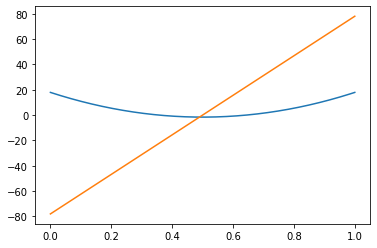

In [302]:
plt.plot(x, y)
plt.plot(x, grad)

In [303]:
return_func_and_grad = tfp.optimizer.bfgs_minimize(value_and_gradients_function=func_to_min,\
     initial_position=[0.5])

In [304]:
return_func_and_grad.position.numpy()

array([0.5], dtype=float32)

In [305]:
tf.sqrt(return_func_and_grad.inverse_hessian_estimate)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>